# Evaluating _die_ and _dat_

In [1]:
import torch
from fairseq.models.roberta import RobertaModel
import numpy as np
from tqdm import tqdm
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from pycm import ConfusionMatrix

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/pieterd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
def replace_die_dat(line, flout, fout):
    for i, word in enumerate(nltk.word_tokenize(line)):
        tokens = nltk.word_tokenize(line)
        if word == "die":
            tokens[i] = "dat"
        elif word == "dat":
            tokens[i] = "die"
        elif word == "Dat":
            tokens[i] = "Die"
        elif word == "Die":
            tokens[i] = "Dat"
        
        if word.lower() == "die" or word.lower() == "dat":
            choice = random.getrandbits(1)
            results = TreebankWordDetokenizer().detokenize(tokens)

            if choice:
                output = "{} <sep> {}".format(results, line)            
            else:
                output = "{} <sep> {}".format(line, results)
                
            fout.write(output + "\n")
            flout.write(str(choice) +"\n")   
    

In [8]:
roberta = RobertaModel.from_pretrained(
    './',
    checkpoint_file='/cw/dtaidata/ml/2019-berdt/models/die-dat/10k.pt',
    data_name_or_path="../data/"
)

roberta.eval()  # disable dropout
print("loaded model")

loading archive file ./
| [input] dictionary: 50265 types
| [label] dictionary: 9 types
loaded model


In [9]:
def replace_query_token(sentence):
    tokens = nltk.word_tokenize(sentence)
    tokens_swapped = nltk.word_tokenize(sentence)
    for i, word in enumerate(tokens):
        if word == "_die_":
            tokens[i] = "die"
            tokens_swapped[i] = "dat"

        elif word == "_dat_":
            tokens[i] = "dat"
            tokens_swapped[i] = "die"

        elif word == "_Dat_":
            tokens[i] = "Dat"
            tokens_swapped[i] = "Die"

        elif word == "_Die_":
            tokens[i] = "Die"
            tokens_swapped[i] = "Dat"


        if word.lower() == "_die_" or word.lower() == "_dat_":
            results = TreebankWordDetokenizer().detokenize(tokens)
            results_swapped = TreebankWordDetokenizer().detokenize(tokens_swapped)

            return "{} <sep> {}".format(results, results_swapped)            



## Sanity check

In [10]:
sentence = "Daar loopt _die_ meisje."
tokens = roberta.encode(replace_query_token(sentence))

print(roberta.predict('sentence_classification_head', tokens))

tensor([[-0.0273, -3.6149]], grad_fn=<LogSoftmaxBackward>)


In [13]:
df = pd.read_table("../data/die-dat/test.raw.labels", header=None, names=['labels'])

In [14]:
df['sentence'] = pd.read_table("../data/die-dat/test.raw.sentences", header=None, names=['sentence'])

In [15]:
results = np.ndarray(len(df))
length_ok = np.ones(len(df))
for row in tqdm(df.iterrows(), total=len(df), mininterval=1, position=0, leave=True):
    index = row[0]
    sentence = row[1]['sentence']
    label = row[1]['labels']

    tokens = roberta.encode(sentence)
    if len(tokens) > 512:
        length_ok[index] = 0;
    else:
        results[index] = roberta.predict('sentence_classification_head', tokens).argmax().item()

  4%|▍         | 12143/305095 [19:39<8:37:20,  9.44it/s] 

KeyboardInterrupt: 

In [16]:
index

12144

In [17]:
results

array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
       4.67570909e-310, 4.67570909e-310, 4.67570909e-310])

In [18]:
df['results'] = results


In [19]:
df.head()

,labels,sentence,results
0,1,En die wij ons met name vragen stellen over de...,0.0
1,1,En die wij beraadslagen om te komen tot de bes...,0.0
2,1,"Om juist te zijn, is het fundamenteel die de w...",0.0
3,1,Op dit moment is die niet het geval. <sep> Op ...,0.0
4,1,Nog afgezien van het feit die de lid-staten al...,0.0


In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, aspect="equal")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[3638  334]
 [ 446 7726]]


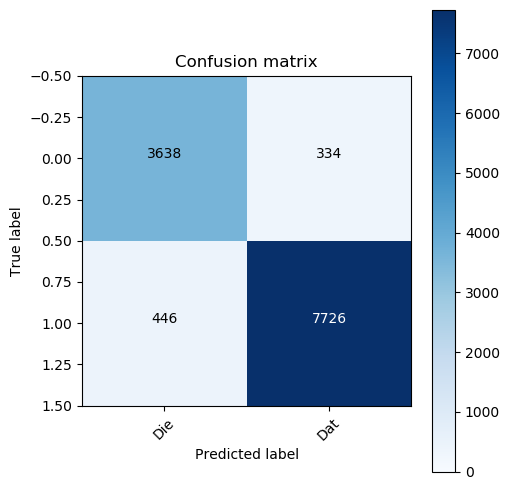

  4%|▍         | 12143/305095 [19:50<8:37:20,  9.44it/s]

In [21]:
cnf_matrix = confusion_matrix(df['labels'][:index], df['results'][:index] == 0.0) # index to evaluate partial runs

np.set_printoptions(precision=2)

title="Confusion matrix"

# Plot normalized confusion matrix
fig = plt.figure(figsize=(5,5), dpi=100)
#fig.set_size_inches(6,6)

plot_confusion_matrix(cnf_matrix, classes=["Die", "Dat"],normalize=False, 
                      title=title, cmap=plt.cm.Blues)


In [22]:
cm = ConfusionMatrix(actual_vector=(df['labels'][:index]==1.0).to_numpy(), predict_vector=(df['results'][:index]==0.0).to_numpy())

In [23]:
cm.stat()

Overall Statistics : 

95% CI                                                            (0.93141,0.94013)
ACC Macro                                                         0.93577
AUNP                                                              0.93067
AUNU                                                              0.93067
Bennett S                                                         0.87154
CBA                                                               0.91811
CSI                                                               0.85534
Chi-Squared                                                       8884.28631
Chi-Squared DF                                                    1
Conditional Entropy                                               0.3418
Cramer V                                                          0.85532
Cross Entropy                                                     0.91219
F1 Macro                                                          0.92756
F1 Micro 